# Preprocessing of the ACM Periodicals Database

In [2]:
import re
import glob
import sys
import json
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from xml.dom import minidom
from xml.parsers.expat import ExpatError
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

len("CCS->Mathematics of computing->Mathematical software".split("->"))-1

2

content -> (article_rec) -> (categories | ccs2012 | keywords | abstract) 
ccs2012
keywords
abstract
concept_significance <br>

kewywords -> kw <br>
abstract -> par

In [ ]:
all_files = glob.glob("periodicals/*/*.xml")
all_files

In [ ]:
def kw_preproc(kw):
    return kw.lower()

In [ ]:
articles_dict  = {"doi":[], "abstract":[], "ft_body":[], "ccs":[], "keywords":[]}
count_ccs      = {}
count_ccs_root = {}
count_ccs_kw   = {}
bad_data_count = 0
bad_xml_count  = 0
count_abstract = 0
count_body     = 0

for i, path in enumerate(tqdm(all_files)):
    

    try:                                             
        mydoc = minidom.parse(path)
    except ExpatError:
        bad_xml_count += 1
        continue


    article_rec    = mydoc.getElementsByTagName('article_rec')

    for articles in article_rec:
        doi_number = articles.getElementsByTagName('doi_number')
        article_id = articles.getElementsByTagName('article_id')

        if(len(doi_number) > 1):
            bad_data_count += 1
            # print("Two doi numbers")

        # print(doi_number[0].firstChild.data)
        if(doi_number[0].firstChild != None):
            articles_dict["doi"].append(doi_number[0].firstChild.data)
        elif(article_id[0].firstChild != None):
            articles_dict["doi"].append(article_id[0].firstChild.data)
        else:
            continue

        abstract = articles.getElementsByTagName('abstract')

        if(len(abstract) > 1):
            bad_data_count += 1
            articles_dict["abstract"].append(abstract[0].getElementsByTagName('par')[0].firstChild.data)
            count_abstract += 1
            # print("Two abstracts")
        elif(len(abstract) == 0):
            bad_data_count += 1
            # print("No Abstract")
            articles_dict["abstract"].append(np.nan)
        else:
            if(abstract[0].getElementsByTagName('par')[0].firstChild != None):
                articles_dict["abstract"].append(abstract[0].getElementsByTagName('par')[0].firstChild.data)
            else:
                articles_dict["abstract"].append(abstract[0].firstChild.data)
            count_abstract += 1

        ft_body = articles.getElementsByTagName('ft_body')

        if(len(ft_body) > 1):
            bad_data_count += 1
            articles_dict["ft_body"].append(ft_body[0].firstChild.data)
            # print("Two bodies")
            count_body     += 1
        elif(len(ft_body) == 0):
            bad_data_count += 1
            # print("No Body")
            articles_dict["ft_body"].append(np.nan)
        else:
            articles_dict["ft_body"].append(ft_body[0].firstChild.data)
            count_body     += 1

        kw_list = []
        for kw in articles.getElementsByTagName('kw'):
            # print(kw.firstChild.data) 
            kw_list.append(kw_preproc(kw.firstChild.data))
            
        if len(kw_list) > 0:
            articles_dict['keywords'].append(kw_list)
        else:
            articles_dict['keywords'].append(np.nan)

        ccs_dict = {}

        for concept in articles.getElementsByTagName('concept'):
            concept_desc         = concept.getElementsByTagName('concept_desc')
            concept_significance = concept.getElementsByTagName('concept_significance')

            significance = int(concept_significance[0].firstChild.data)
            concept_tree = concept_desc[0].firstChild.data
            
            if('->' in concept_tree):
                concept_root = concept_tree.split("->")[1]
            elif('~' in concept_tree):
                concept_root = concept_tree.split("~")[0]
            else:
                # print(concept_tree)
                concept_root = concept_tree
            # print(concept_tree)
            # print(concept_root)
            # print(significance)

            ## We count concepts only once !
            if concept_tree not in ccs_dict.keys():

                if concept_root in count_ccs_root.keys():
                    count_ccs_root[concept_root] += 1
                else:
                    count_ccs_root[concept_root]  = 1
            
                if concept_tree in count_ccs.keys():
                    count_ccs[concept_tree] += 1
                else:
                    count_ccs[concept_tree]  = 1

                if concept_tree not in count_ccs_kw.keys() and len(kw_list) > 0:
                    count_ccs_kw[concept_tree] = {}
                
                for kw in kw_list:
                    if kw in count_ccs_kw[concept_tree].keys():
                        count_ccs_kw[concept_tree][kw] += 1
                    else:
                        count_ccs_kw[concept_tree][kw]  = 1

                ## Adds concept to ccs_dict with sign level
                ccs_dict[concept_tree] = significance

            elif concept_tree in ccs_dict.keys():
                ## Adds concept to ccs_dict with MAX sign level
                ccs_dict[concept_tree] = max(significance, ccs_dict[concept_tree])        

        
        articles_dict['ccs'].append(ccs_dict)



print(bad_data_count, bad_xml_count)

In [ ]:
print("Number of abstracts: ", count_abstract)
print("Number of bodies: ", count_body)

#### Save the created data:

In [ ]:
with open('Data/count_ccs.json', 'w') as fp:
    json.dump(count_ccs, fp)

with open('Data/count_ccs_root.json', 'w') as fp:
    json.dump(count_ccs_root, fp)

with open('Data/count_ccs_kw.json', 'w') as fp:
    json.dump(count_ccs_kw, fp)

with open('Data/articles_dict.json', 'w') as fp:
    json.dump(articles_dict, fp)

### Stats on the ACM DataBase

##### Load Data

In [2]:
with open('Data/count_ccs.json', 'r') as fp:
    count_ccs = json.load(fp)
 
    # Print the type of data variable
    print("Type:", type(count_ccs))

with open('Data/count_ccs_root.json', 'r') as fp:
    count_ccs_root = json.load(fp)

with open('Data/count_ccs_kw.json', 'r') as fp:
    count_ccs_kw = json.load(fp)

with open('Data/articles_dict.json', 'r') as fp:
    articles_dict = json.load(fp)


Type: <class 'dict'>


##### Descr of the Created DataFrame

In [3]:
articles_df = pd.DataFrame(articles_dict)
articles_df.tail()

,doi,abstract,ft_body,ccs,keywords
107908,10.1145/2767134,<p>Online social media allow users to interact...,\n Detection of Political Manipulation in Onli...,{'CCS->Information systems->World Wide Web->We...,"[online social media, machine learning, opinio..."
107909,10.1145/2767135,<p>A classifier that determines if a webpage i...,\n Improving Researcher Homepage Classi.cation...,{'CCS->Information systems->Information retrie...,"[researcher homepage classification, co-traini..."
107910,10.1145/2789211,<p>There has been a recent swell of interest i...,\n Diversionary Comments under Blog Posts JING...,{'Mathematics of computing~Bayesian networks':...,"[diversionary comments, classification, corefe..."
107911,10.1145/2790304,<p>This work addresses the problem of estimati...,\n Estimating Clustering Coef.cients and Size ...,{'CCS->Theory of computation->Design and analy...,"[estimation, clustering coefficient, sampling,..."
107912,10.1145/2812812,<p>The Web 2.0 brought new requirements to the...,\n Fona: Quantitative Metric to Measure Focus ...,{'CCS->Hardware': 500},"[aria, focus navigation, web accessibility]"


In [4]:
## Number of articles with keywords
articles_df.shape[0] - articles_df.keywords.isna().sum()

40466

In [7]:
## Number of articles with ccs
articles_df.shape[0] - articles_df.ccs.isna().sum()

107913

In [ ]:
articles_df['ccs'].iloc[1]

#### Preprocessing text data
Our pre-processing steps are:
- Removing HTML tags like `<p>`
- Removing URLs
- Removing email addresses
- Removing soft hyphens (\xag)
- Remove punctuation `,.;@#?!&$()`
- Lower casing
- Tokenization
- Removing Stop words
- Lemmatization (to understand meaning in examples)
- Concatenation and seperation by spaces

In [4]:
import nltk
from nltk.stem import WordNetLemmatizer
from Scripts.util import stringPreprocessing

stopwords = nltk.corpus.stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package wordnet to /home/jcl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jcl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [149]:
## Example here
str_test = """
<p><>Hello, the keywords here <i>are</i> <b>Ham</b> and (<b>Cheese</b>). 
Let us see how it is going to handle every characters in this string. (TESTs?|TEST)<></p><br>\n 
jc@l.com @ word-ing is good here: https://liveloveresearch.com. 
from DOI: http://dx.doi.org/10.1145/2790304 
"""
stringPreprocessing(str_test)

'hello keywords ham cheese let u see going handle every character string test test word-ing good'

##### Preprocessing abstracts, bodies, and keywords

In [234]:
### Processing abstracts, bodies, and keywords
articles_df['abstract_processed'] = articles_df.abstract.apply(lambda x: stringPreprocessing(x) if not pd.isnull(x) else np.nan)
articles_df['ft_body_processed']  = articles_df.ft_body.apply(lambda x: stringPreprocessing(x) if not pd.isnull(x) else np.nan)
articles_df['kw_processed']       = articles_df.keywords.apply(lambda x: [stringPreprocessing(kw) for kw in x] if hasattr(x, "__len__") else np.nan)

In [17]:
## Check if we maintained the same amount of articles with keywords
articles_df.keywords.isna().sum() == articles_df.kw_processed.isna().sum()

True

In [236]:
articles_df[['abstract_processed', 'ft_body_processed', 'kw_processed']].tail()

,abstract_processed,ft_body_processed,kw_processed
107908,online social medium allow user interact one a...,detection political manipulation online commun...,"[online social medium, machine learning, opini..."
107909,classifier determines webpage relevant specifi...,improving researcher homepage classi cation un...,"[researcher homepage classification, co-traini..."
107910,recent swell interest analysis blog comment ho...,diversionary comment blog post jing wang cleme...,"[diversionary comment, classification, corefer..."
107911,work address problem estimating social network...,estimating clustering coef cients size social ...,"[estimation, clustering coefficient, sampling,..."
107912,web 2 0 brought new requirement architecture w...,fona quantitative metric measure focus navigat...,"[aria, focus navigation, web accessibility]"


##### Preprocessing CCS concepts
FULL POWER OF APPLY [HERE](https://stackoverflow.com/questions/20829748/pandas-assigning-multiple-new-columns-simultaneously)

In [186]:
## Example
print(articles_df['ccs'].iloc[2002])
ExtractMainRootLeafAndConcepts(articles_df['ccs'].iloc[2002])

{'CCS->Mathematics of computing->Mathematical analysis->Functional analysis->Approximation': 100, 'CCS->Theory of computation->Design and analysis of algorithms->Approximation algorithms analysis': 100, 'CCS->Mathematics of computing->Mathematical analysis->Numerical analysis->Computations on matrices': 500, 'CCS->Computing methodologies->Symbolic and algebraic manipulation->Symbolic and algebraic algorithms->Linear algebra algorithms': 500}


('mathematics computing',
 'computation matrix',
 [('mathematics computing', 'computation matrix'),
  ('computing methodology', 'linear algebra algorithm')])

In [ ]:
from Scripts.util import ExtractMainRootLeafAndConcepts
res = articles_df['ccs'].apply(ExtractMainRootLeafAndConcepts)
res_np = np.array([np.array(el) for el in res])

articles_df[['main_concept_root', 'main_concept_leaf', 'high_Importance_concept_roots_and_leafs']] = res_np

In [4]:
articles_df[['main_concept_root', 'main_concept_leaf', 'high_Importance_concept_roots_and_leafs']].tail()

,main_concept_root,main_concept_leaf,high_Importance_concept_roots_and_leafs
107908,information system,web application,"[('information system', 'web application'), ('..."
107909,information system,information retrieval,"[('information system', 'information retrieval')]"
107910,mathematics computing,bayesian network,"[('mathematics computing', 'bayesian network')..."
107911,theory computation,design analysis algorithm,"[('theory computation', 'design analysis algor..."
107912,NaN,NaN,"[(nan, nan)]"


###### Saving Processed Data

In [235]:
articles_df.to_csv("Data/data_processed.csv", index=False)

###### Loading the data

In [3]:
articles_df = pd.read_csv("Data/data_processed.csv")

#### Stats on abstracts

In [238]:
## Number of articles with abstracts
articles_df.shape[0] - articles_df.abstract.isna().sum()

76508

In [239]:
articles_abstract_df = articles_df.dropna(subset="abstract_processed")
depth_df = pd.DataFrame({"article": articles_abstract_df['doi'], "abstract word length": [len(abs.split()) for abs in articles_abstract_df['abstract_processed']]})
depth_df.describe()

,abstract word length
count,76508.000000
mean,85.064751
std,59.098059
min,0.000000
25%,48.000000
50%,79.000000
75%,114.000000
max,2869.000000


#### Stats on Bodies

In [240]:
## Number of articles with ft_body
articles_df.shape[0] - articles_df.ft_body.isna().sum()

106152

In [241]:
articles_bodies_df = articles_df.dropna(subset="ft_body_processed")
depth_df = pd.DataFrame({"article": articles_bodies_df['doi'], "abstract word length": [len(bd.split()) for bd in articles_bodies_df['ft_body_processed']]})
depth_df.describe()

,abstract word length
count,106152.000000
mean,3500.733731
std,3595.294293
min,0.000000
25%,781.000000
50%,2304.000000
75%,5615.000000
max,111475.000000


#### Stats on CCS concepts

In [245]:
## Number of articles with ccs concepts
articles_df.shape[0] - articles_df['high_Importance_concept_roots_and_leafs'].isna().sum()

85278

##### Number of different leafs and roots

In [220]:
root_occ = pd.DataFrame(articles_df['main_concept_root'].value_counts())
num_diff_roots = (root_occ > 1).sum()
print("There are {0} different roots".format(num_diff_roots))
root_occ.head(22)

There are main_concept_root    13
dtype: int64 different roots


,main_concept_root
software engineering,16770
social professional topic,9665
computing methodology,8765
information system,7512
theory computation,5835
network,5297
applied computing,5041
mathematics computing,4688
human-centered computing,4661
general reference,4024


In [229]:
leaf_occ = pd.DataFrame(articles_df['main_concept_leaf'].value_counts())
num_diff_leafs = (leaf_occ > 2).sum()
print("There are {0} different leafs".format(num_diff_leafs))
leaf_occ.describe()

There are main_concept_leaf    964
dtype: int64 different leafs


,main_concept_leaf
count,1327.000000
mean,60.797287
std,169.337994
min,1.000000
25%,2.000000
50%,10.000000
75%,51.000000
max,2687.000000


In [230]:
leaf_occ.head()

,main_concept_leaf
language type,2687
human computer interaction hci,2524
computer science education,2061
document type,1685
compiler,1388


##### Most popular concepts

In [59]:
N = 15
ccs_ids = np.argsort(list(count_ccs.values()))[::-1]
popular_ccs = np.array(list(count_ccs.keys()))[ccs_ids][:N]
print("Here is a list of the most popular concepts: ")
print(popular_ccs)
print("And here are their occurences:", np.sort(list(count_ccs.values()))[::-1][:N])
print("There is {0} concepts with keywords out of {1} concepts.".format(len(count_ccs_kw), len(count_ccs)))

Here is a list of the most popular concepts: 
['CCS->Software and its engineering->Software notations and tools->General programming languages->Language types'
 'CCS->Human-centered computing->Human computer interaction (HCI)'
 'CCS->General and reference->Cross-computing tools and techniques->Performance'
 'CCS->Social and professional topics->Professional topics->Computing education->Computing education programs->Computer science education'
 'CCS->Software and its engineering->Software notations and tools->Compilers'
 'CCS->Computer systems organization->Dependable and fault-tolerant systems and networks'
 'CCS->Software and its engineering->Software creation and management->Software development process management'
 'CCS->Networks->Network performance evaluation'
 'CCS->Information systems->Information retrieval'
 'CCS->Hardware->Communication hardware, interfaces and storage'
 'CCS->Networks->Network protocols' 'CCS->Networks'
 'CCS->Applied computing->Education'
 'CCS->Social and p

##### Stats on Width of Concepts

In [231]:
depth_df = pd.DataFrame({"doi": articles_df['doi'], "occurences": [len(dic.values()) for dic in articles_df['ccs']]})
depth_df.describe()

,occurences
count,107913.000000
mean,2.839843
std,2.559154
min,0.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,34.000000


array([[<AxesSubplot:title={'center':'occurences'}>]], dtype=object)

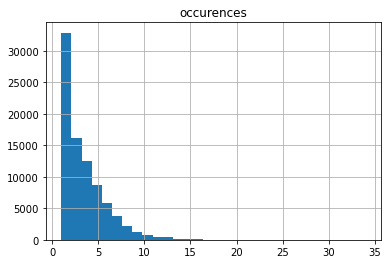

In [232]:
depth_df[depth_df['occurences'] > 0].hist(bins = 30)

##### Stats on Depth of Concepts

In [233]:
depth_of_concepts = [len(ccs.split("->"))-1 if '->' in ccs else len(ccs.split("~"))-1 if '~' in ccs else 1 for ccs in count_ccs.keys()]

print(np.median(depth_of_concepts), np.mean(depth_of_concepts), np.max(depth_of_concepts), np.min(depth_of_concepts))

1.0 1.8969149736644093 6 1


Min théorique est de 1, max théorique est de 6

##### Number of different CCS roots:

In [8]:
ccs_root_df = pd.DataFrame({"ccs_root": count_ccs_root.keys(), "occurences": count_ccs_root.values()})
ccs_root_df.describe()

,occurences
count,78.000000
mean,3928.923077
std,10408.953072
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,60107.000000


In [9]:
ccs_root_df[ccs_root_df['occurences'] > 5].sort_values(by=['occurences'], ascending=False)

,ccs_root,occurences
5,Software and its engineering,60107
6,Computing methodologies,35723
8,Theory of computation,30762
1,Information systems,29861
2,Social and professional topics,28934
3,Applied computing,19945
9,Networks,19037
0,Mathematics of computing,17720
10,Computer systems organization,16413
7,General and reference,15686


#### Keywords Stats

##### On a single ccs concept

In [ ]:
ccs_name = 'CCS->Human-centered computing->Human computer interaction (HCI)'

def create_kw_occ_df(ccs_name):
    kw_occ_df = pd.DataFrame({"keywords": count_ccs_kw[ccs_name].keys(), "occurences": count_ccs_kw[ccs_name].values()})
    return kw_occ_df

kw_occ_df = create_kw_occ_df(ccs_name)
kw_occ_df.describe()

In [ ]:
kw_occ_df.hist(bins=30, alpha=0.5)

In [ ]:
kw_occ_df[kw_occ_df['occurences'] > 5].sort_values(by=['occurences'], ascending=False)

##### On a all ccs concept

In [255]:
def countValuesArray(array_of_values):
    occ = pd.DataFrame(pd.DataFrame(array_of_values).value_counts())
    return occ


In [267]:
articles_kw_ccs_df = articles_df.dropna(subset = ["kw_processed", "main_concept_root"])
agg_ccs_df = articles_kw_ccs_df.groupby(['main_concept_root']).agg({'kw_processed': sum})

In [278]:
countValuesArray(agg_ccs_df[agg_ccs_df.index == 'human-centered computing'].iloc[0].array[0]).head(20)

,0
0,
human-computer interaction,61
user interface,43
virtual reality,29
crowdsourcing,26
usability,25
collaboration,24
accessibility,24
information visualization,24
evaluation,22


##### Stats over all keywords

In [36]:
articles_kw_df = articles_df.dropna(subset = "kw_processed")

kwp_agg_dict  = {}

for val in articles_kw_df.kw_processed:
    for kw in val:

        if kw in kwp_agg_dict.keys():
            kwp_agg_dict[kw] += 1
        else:
            kwp_agg_dict[kw]  = 1

print(len(kwp_agg_dict))

71085


In [54]:
kwp_agg_df = pd.DataFrame({"keyword_names": kwp_agg_dict.keys(), "occurences": kwp_agg_dict.values()})
kwp_agg_df.sort_values(by=['occurences'], ascending=False).head(15)

,keyword_names,occurences
315,scheduling,479
408,optimization,411
523,java,400
534,security,375
841,simulation,341
591,concurrency,337
1519,performance,332
1281,wireless sensor network,315
496,compiler,300
23,education,273


In [49]:
len(kwp_agg_df[kwp_agg_df['occurences'] >= 3])

11177

In [50]:
kwp_agg_df.describe()

,occurences
count,71085.000000
mean,2.569445
std,8.912610
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,479.000000


In [52]:
## Prints all useless keywords eliminated by preprocessing

# Linearizes raw keywords
kw_dict = {}
for kw_list in articles_df.dropna(subset='keywords').keywords:
    for kw in kw_list:
        kw_dict[kw] = 1


# Prints the useless kw
for kw in kw_dict.keys():
    kwp = stringPreprocessing(kw)
    if(kwp == ''):
        print(kw, "->", kwp)


can -> 
it -> 
a# -> 
here -> 
its -> 
who is who -> 
as if -> 
the other -> 
now -> 
????? -> 
is -> 
ll -> 
same -> 
at -> 
me -> 
ma -> 
has -> 
nor -> 
